<a href="https://colab.research.google.com/github/Serbeld/RX-COVID-19/blob/master/Pretraining_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install lime

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd

plt.rcParams["figure.figsize"] = (10,5)


In [0]:
#Loading the dataset
!pip install h5py
import h5py

from google.colab import drive,files
drive.mount('/content/drive')

hdf5_path = '/content/drive/My Drive/Dataset COVID-19/Desv/Dataset_4C_D_RGB.hdf5'

dataset = h5py.File(hdf5_path, "r")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pylab as plt

#train
train_img = dataset["train_img"]

xt = np.array(train_img)
yt = np.array(dataset["train_labels"])

#test
testX = np.array(dataset["test_img"])
testY = np.array(dataset["test_labels"])

#Validation
xval = np.array(dataset["val_img"])
yval = np.array(dataset["val_labels"])

In [0]:
print("Training Shape: "+ str(xt.shape))
print("Validation Shape: "+ str(xval.shape))
print("Testing Shape: "+ str(testX.shape))

Training Shape: (2169, 512, 512, 3)
Validation Shape: (465, 512, 512, 3)
Testing Shape: (465, 512, 512, 3)


In [0]:
#Categorical values or OneHot
import keras

num_classes = 4 

yt = keras.utils.to_categorical(yt,num_classes)
testY = keras.utils.to_categorical(testY,num_classes)
yval = keras.utils.to_categorical(yval,num_classes)

print()
print('Normal:              0                    [1 0 0 0]')
print('Pneumonia Vir:       1                    [0 1 0 0]')
print('Pneumonia Bact:      2                    [0 0 1 0]')
print('COVID-19:            3                    [0 0 0 1]')


Normal:              0                    [1 0 0 0]
Pneumonia Vir:       1                    [0 1 0 0]
Pneumonia Bact:      2                    [0 0 1 0]
COVID-19:            3                    [0 0 0 1]


Using TensorFlow backend.



Output:                        [0. 1. 0. 0.]


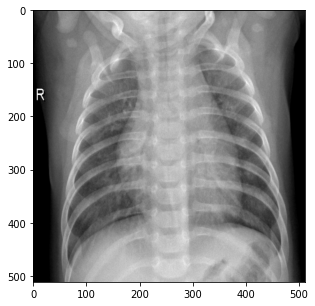

In [0]:
#Image
num_image = 30

print()
print("Output:                        "+ str(yt[num_image]))

imagen =  xt[num_image]
plt.imshow(imagen)
plt.show()

In [0]:
## global params
INIT_LR = 2e-5  # learning rate
EPOCHS = 10  # training epochs
BS = 8  # batch size

In [0]:
## build network

#Inputs
inputs = Input(shape=(512, 512, 3), name='images')

#Inception Model
output1 = inception_v3.InceptionV3(include_top=False,weights= None, 
                                  input_shape=(512, 512, 3),
                                  classes = 4)(inputs)

#AveragePooling2D
output = AveragePooling2D(pool_size=(4, 4), strides=None, 
                          padding='valid',name='AvgPooling')(output1)

#Flattened
output = Flatten(name='Flatten')(output)

#ReLU layer
output = Dense(1000, activation = 'relu',name='ReLU')(output)

#Dropout
output = Dropout(0.35,name='Dropout')(output)

#Dense layer
output = Dense(4, activation='softmax',name='softmax')(output)

# the actual model train)
model = Model(inputs=inputs, outputs=output)

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
AvgPooling (AveragePooling2D (None, 3, 3, 2048)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
ReLU (Dense)                 (None, 1000)              18433000  
_________________________________________________________________
Dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
softmax (Dense)              (None,

In [0]:
## train
print("[INFO] training head...")
H = model.fit({'images': xt}, 
              {'softmax': yt}, 
              batch_size = BS,
              epochs = EPOCHS,
              validation_data=(xval, yval),
              shuffle=True)


[INFO] training head...
Epoch 1/10
272/272 [==============================] - 61s 225ms/step - loss: 0.9374 - accuracy: 0.6077 - val_loss: 2.0272 - val_accuracy: 0.3183
Epoch 2/10
272/272 [==============================] - 59s 216ms/step - loss: 0.7540 - accuracy: 0.6791 - val_loss: 0.6739 - val_accuracy: 0.7011
Epoch 3/10
272/272 [==============================] - 59s 217ms/step - loss: 0.6638 - accuracy: 0.7160 - val_loss: 0.5786 - val_accuracy: 0.7613
Epoch 4/10
272/272 [==============================] - 59s 217ms/step - loss: 0.5855 - accuracy: 0.7423 - val_loss: 0.5691 - val_accuracy: 0.7763
Epoch 5/10
272/272 [==============================] - 59s 217ms/step - loss: 0.5269 - accuracy: 0.7672 - val_loss: 0.5560 - val_accuracy: 0.7742
Epoch 6/10
272/272 [==============================] - 59s 217ms/step - loss: 0.4903 - accuracy: 0.7948 - val_loss: 0.5911 - val_accuracy: 0.7505
Epoch 7/10
272/272 [==============================] - 59s 216ms/step - loss: 0.4482 - accuracy: 0.7994 - v

In [0]:
print("[INFO] saving COVID-19 detector model...")
model.save("/content/drive/My Drive/COVID-19/Pretrained_covid19_Inception_cero.model", save_format="h5")

[INFO] saving COVID-19 detector model...


In [0]:
## eval
print("[INFO] evaluating network...")
predIdxs = (model.predict(testX, batch_size=BS))
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability
#print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[INFO] evaluating network...
[[136   4   1   1]
 [  4 114  22   1]
 [  1  53 109   0]
 [  1   2   0  16]]
acc: 0.5376
sensitivity: 0.9714
specificity: 0.9661


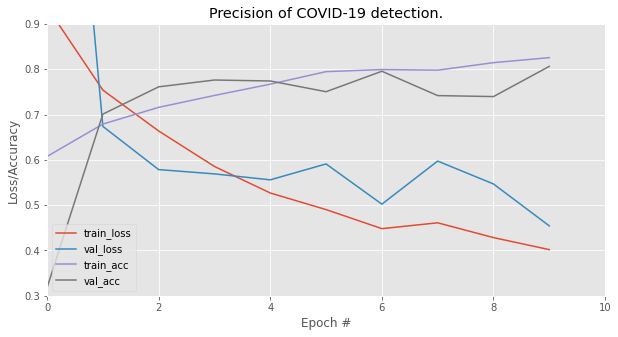

In [0]:
## explain
N = EPOCHS
plt.style.use("ggplot")
plt.figure(1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision of COVID-19 detection.")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.axis([0, EPOCHS, 0.3, 0.9])
plt.savefig("/content/drive/My Drive/COVID-19/Pretrained_cero_plot_Inception.png")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


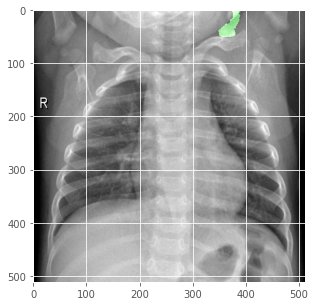


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 2 - predicted: 1


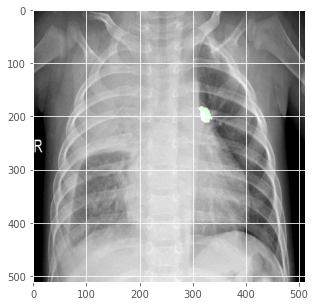


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 2 - predicted: 1


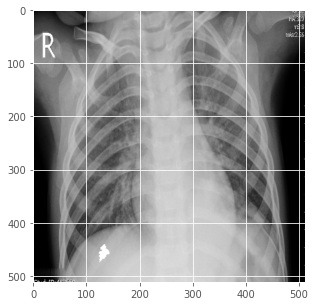


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


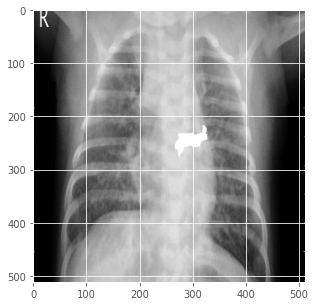


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 2 - predicted: 1


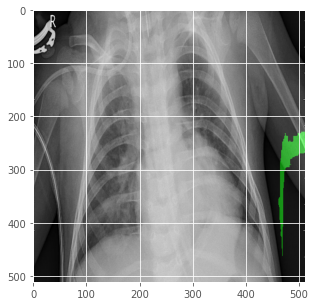

> label: 3 - predicted: 3


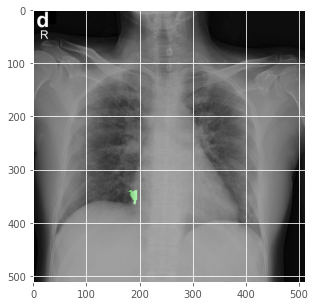


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


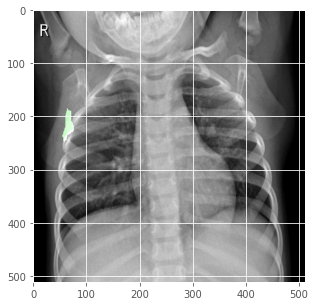


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 2


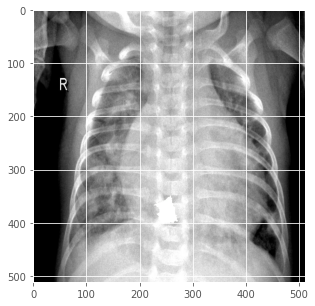

> label: 0 - predicted: 0


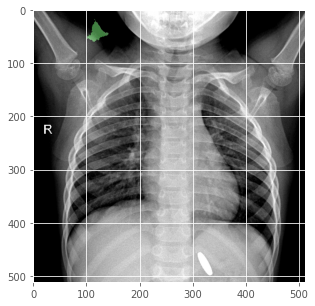

> label: 0 - predicted: 0


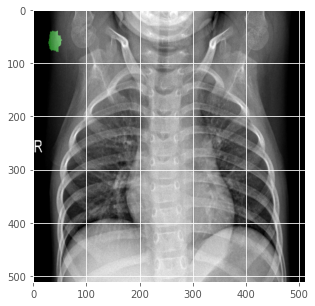


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 2 - predicted: 1


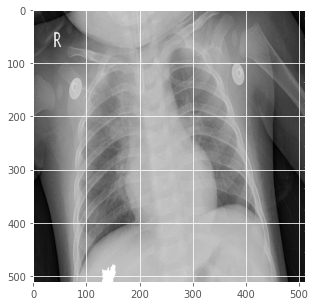

> label: 1 - predicted: 1


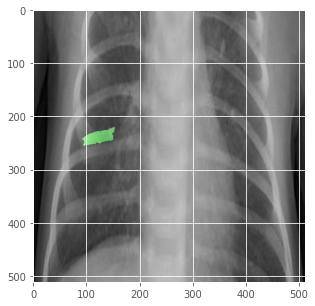


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 2 - predicted: 2


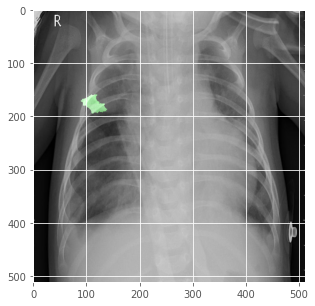


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


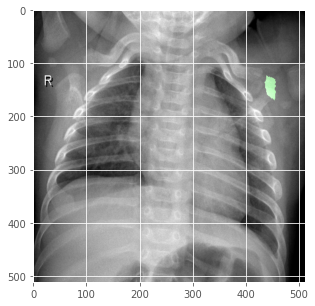


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 2 - predicted: 2


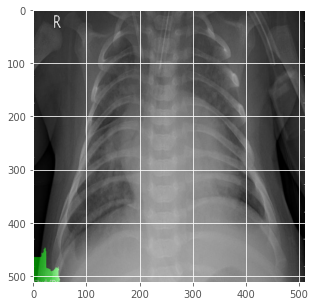

In [0]:
plt.figure(2)
for ind in range(15): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=True)
    plt.imshow((mark_boundaries(temp/2 , mask) +testX[ind])/255)
    plt.savefig("/content/drive/My Drive/COVID-19/Pretrained_pulmons_inception_"+str(ind)+".png")
    plt.show()